In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
pwd = os.getcwd()

df = pd.read_csv(pwd + '/flights.csv')

In [3]:
df.tail(10)

,year,month,passengers
134,1960,March,419
135,1960,April,461
136,1960,May,472
137,1960,June,535
138,1960,July,622
139,1960,August,606
140,1960,September,508
141,1960,October,461
142,1960,November,390
143,1960,December,432


In [4]:
df.shape

(144, 3)

In [5]:
df.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [6]:
# Check for missing values
df.isnull().sum()

year          0
month         0
passengers    0
dtype: int64

In [7]:
# Convert month names to numbers
df['month'] = pd.to_datetime(df['month'], format='%B').dt.month

# Create a datetime column
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

In [8]:
df.head()

,year,month,passengers,date
0,1949,1,112,1949-01-01
1,1949,2,118,1949-02-01
2,1949,3,132,1949-03-01
3,1949,4,129,1949-04-01
4,1949,5,121,1949-05-01


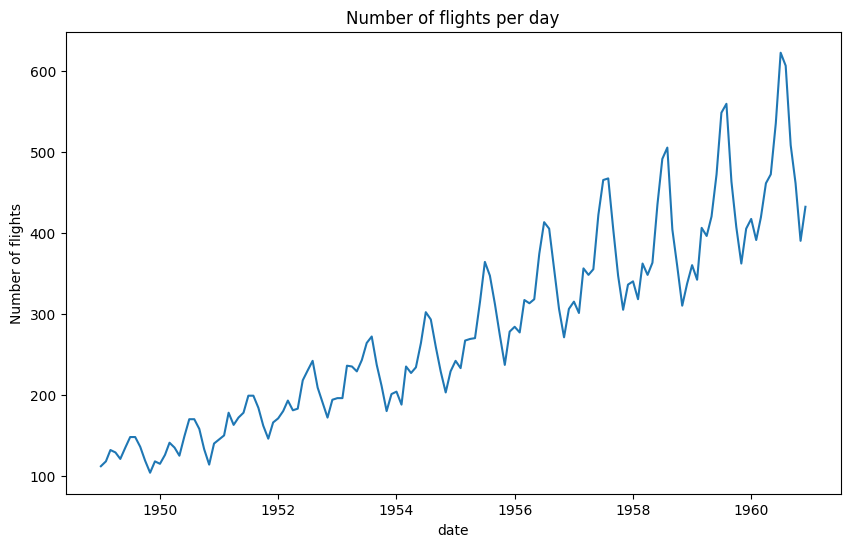

In [9]:
#graph of the times series of the number of flights
plt.figure(figsize=(10,6))
sns.lineplot(x='date', y='passengers', data=df)
plt.title('Number of flights per day')
plt.ylabel('Number of flights')
plt.show()


## Modelo de série temporal

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [11]:
# Fit SARIMA model (Seasonal ARIMA)
model = SARIMAX(df['passengers'], order=(1,1,1), seasonal_order=(1,1,1,12))
result = model.fit()

In [12]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.149
Date:                            Mon, 17 Feb 2025   AIC                           1022.299
Time:                                    23:48:29   BIC                           1036.675
Sample:                                         0   HQIC                          1028.140
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1272      0.356     -0.357      0.721      -0.825       0.570
ma.L1         -0.2149      0.325     -0.660      0.509      -0.853       0.423
ar.S.L12      -0.9272      0.214     -4.341      0.000      -1.346      -0.509
ma.S.L12       0.8395      0.309      2.717      0.007       0.234       1.445
sigma2       130.7826     15.420      8.481      0.000     100.559     161.006
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.05
Prob(Q):                              0.99   Prob(JB):                         0.03
Heteroskedasticity (H):               2.65   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
import itertools
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")  # Ignore convergence warnings

p = q = range(0, 2) 
d = range(1, 2)  
P = Q = range(0, 2)  
D = range(1, 2)  
seasonal_period = 12

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [seasonal_period]))

best_aic = float("inf")
best_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(
                df["passengers"],
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            results = model.fit(disp=0)  # No verbose output

            if results.aic < best_aic:
                best_aic = results.aic
                best_model = (param, param_seasonal)
                print(f"New Best: SARIMA{param}x{param_seasonal} - AIC: {best_aic}")

        except Exception as e:
            print(f"Skipping SARIMA{param}x{param_seasonal} - Error: {e}")



New Best: SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: 1024.4816429833895
New Best: SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC: 937.7995265380529
New Best: SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC: 920.6308317604729
New Best: SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC: 920.3192974989254


In [32]:
#sarima summary
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -456.160
Date:                            Tue, 18 Feb 2025   AIC                            920.319
Time:                                    00:03:39   BIC                            931.368
Sample:                                         0   HQIC                           924.805
                                            - 144                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3351      0.076     -4.403      0.000      -0.484      -0.186
ar.S.L12      -0.5597      0.285     -1.967      0.049      -1.117      -0.002
ma.S.L12       0.4077      0.336      1.212      0.225      -0.251       1.067
sigma2       140.2869     18.080      7.759      0.000     104.852     175.722
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.95
Prob(Q):                              0.98   Prob(JB):                         0.14
Heteroskedasticity (H):               2.51   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

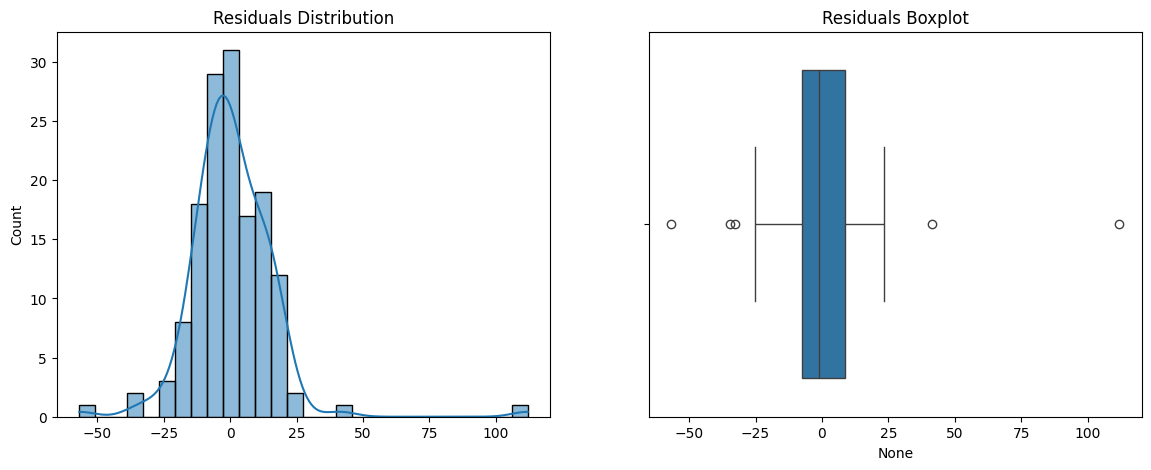

     lb_stat  lb_pvalue
10  7.012066   0.724305


In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Fit the best model
best_model = sm.tsa.statespace.SARIMAX(df['passengers'],
                                       order=best_model[0],
                                       seasonal_order=best_model[1],
                                       enforce_stationarity=False,
                                       enforce_invertibility=False).fit()

# Residual diagnostics
residuals = best_model.resid

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(residuals, kde=True, ax=ax[0])  # Check normality
ax[0].set_title("Residuals Distribution")

sns.boxplot(x=residuals, ax=ax[1])  # Check outliers
ax[1].set_title("Residuals Boxplot")

plt.show()

# Ljung-Box test for autocorrelation
print(acorr_ljungbox(residuals, lags=[10], return_df=True))


In [16]:
#com Prophet (Facebook)
from prophet import Prophet

In [17]:
# Prepare data for Prophet
df_prophet = df.reset_index().rename(columns={'date': 'ds', 'passengers': 'y'})

# Fit Prophet model
model = Prophet()
model.fit(df_prophet)

23:52:48 - cmdstanpy - INFO - Chain [1] start processing
23:52:48 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Make future predictions
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

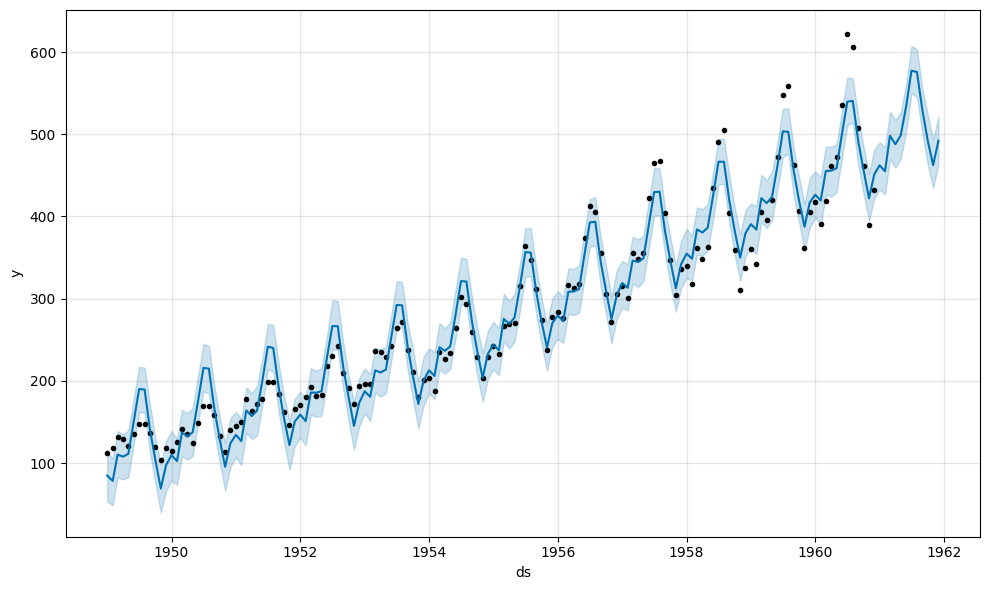

In [19]:
# Plot forecast
model.plot(forecast)
plt.show()

In [20]:
# Initialize Prophet with tuned parameters
model = Prophet(
    changepoint_prior_scale=0.05,  # Controls trend flexibility (default=0.05)
    seasonality_prior_scale=10.0,  # Controls seasonality flexibility (default=10.0)
    holidays_prior_scale=10.0,     # Controls holiday effects
    weekly_seasonality=False,      # Disabling weekly seasonality for monthly data
    yearly_seasonality=True        # Enabling yearly seasonality
)

# Add custom seasonality (if needed)
model.add_seasonality(name="monthly", period=30.5, fourier_order=5)

# Fit the model
model.fit(df_prophet)

23:52:49 - cmdstanpy - INFO - Chain [1] start processing
23:52:49 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
Q1 = df_prophet['y'].quantile(0.25)
Q3 = df_prophet['y'].quantile(0.75)
IQR = Q3 - Q1

# Filter out extreme values
df_clean = df_prophet[(df_prophet['y'] > Q1 - 1.5 * IQR) & (df_prophet['y'] < Q3 + 1.5 * IQR)]

In [22]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)

print(df_p[['horizon', 'rmse', 'mape']])  # Check errors

  0%|          | 0/19 [00:00<?, ?it/s]

23:52:50 - cmdstanpy - INFO - Chain [1] start processing
23:53:08 - cmdstanpy - INFO - Chain [1] done processing
23:53:08 - cmdstanpy - INFO - Chain [1] start processing
23:53:09 - cmdstanpy - INFO - Chain [1] done processing
23:53:09 - cmdstanpy - INFO - Chain [1] start processing
23:53:09 - cmdstanpy - INFO - Chain [1] done processing
23:53:09 - cmdstanpy - INFO - Chain [1] start processing
23:53:10 - cmdstanpy - INFO - Chain [1] done processing
23:53:10 - cmdstanpy - INFO - Chain [1] start processing
23:53:11 - cmdstanpy - INFO - Chain [1] done processing
23:53:11 - cmdstanpy - INFO - Chain [1] start processing
23:53:11 - cmdstanpy - INFO - Chain [1] done processing
23:53:12 - cmdstanpy - INFO - Chain [1] start processing
23:53:12 - cmdstanpy - INFO - Chain [1] done processing
23:53:12 - cmdstanpy - INFO - Chain [1] start processing
23:53:13 - cmdstanpy - INFO - Chain [1] done processing
23:53:13 - cmdstanpy - INFO - Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1]

     horizon        rmse      mape
0    40 days   40.040211  0.101041
1    42 days  121.541836  0.235079
2    46 days  120.789824  0.229610
3    47 days  118.956465  0.200977
4    48 days  119.485646  0.212314
..       ...         ...       ...
165 359 days   56.074973  0.154895
166 360 days   55.447715  0.155391
167 362 days   56.267172  0.152357
168 364 days   56.299007  0.153599
169 365 days   56.638005  0.156548

[170 rows x 3 columns]


In [23]:
from prophet.plot import plot_components_plotly

plot_components_plotly(model, forecast)


In [25]:
#comparando prophet com SARIMA

from sklearn.metrics import mean_absolute_percentage_error

# Create test set (last 12 months)
df_test = df.iloc[-12:]

# Forecast using SARIMA
sarima_forecast = best_model.forecast(steps=12)

# Forecast using Prophet (already fitted)
prophet_forecast = forecast['yhat'][-12:].values

# Compare accuracy
sarima_mape = mean_absolute_percentage_error(df_test['passengers'], sarima_forecast)
prophet_mape = mean_absolute_percentage_error(df_test['passengers'], prophet_forecast)

print(f"SARIMA MAPE: {sarima_mape:.2%}")
print(f"Prophet MAPE: {prophet_mape:.2%}")

SARIMA MAPE: 7.69%
Prophet MAPE: 9.45%
